# Interactive view of Archive's Pareto front

First let's fit a simple model to have something to work with

In [1]:
if False: # installing plotly if you dont have it yet
    !pip install plotly matplotlib seaborn > /dev/null

import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from pybrush import BrushRegressor, individual, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import graphviz

# load data
df = pd.read_csv('../examples/datasets/d_enc.csv')
X = df.drop(columns='label')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(614, 8) (154, 8) (614,) (154,)


In [2]:
# set verbosity==2 to see the full report
est = BrushRegressor(
    functions=['SplitBest','Add','Mul','Div','Sub'], # ,'Sin','Cos','Exp','Logabs'
    max_gens=100,
    pop_size=100,
    max_depth=5,
    objectives=["scorer", "complexity"],
    scorer='mse',
    validation_size=0.2,
    verbosity=1
).fit(X_train,y_train)

print('score:', est.score(X_train, y_train))

Completed 100% [====================]
score: 0.9698785794432052


In [3]:
# it will contain all individuals, differently than the archive
print("population size:", len(est.population_))
print("archive size   :", len(est.archive_))

population size: 100
archive size   : 29


In [4]:
archive_estimators_ = est.archive_

In [5]:
train_dataset = est.train_
val_dataset   = est.validation_
test_dataset  = Dataset(X=X_test, feature_names=X.columns.to_list(),
                        ref_dataset = train_dataset)

Creating the interactive plot.

In [6]:
# Auxiliary functions
def check_dominance(p1,p2):
    flag1, flag2 = 0, 0

    for o1,o2 in zip(p1,p2):
        if   o1 < o2: flag1 = 1
        elif o1 > o2: flag2 = 1

    if   flag1==1 and flag2 == 0: return 1
    elif flag1==0 and flag2 == 1: return -1
    else                        : return 0

def front(obj1,obj2):
    rank = []
    assert(len(obj1)==len(obj2))
    n_inds = len(obj1)
    front = []

    for i in np.arange(n_inds):
        p = (obj1[i],obj2[i])
        dcount = 0
        dom = []
        for j in np.arange(n_inds):
            q = (obj1[j],obj2[j])
            compare = check_dominance(p,q)
            if compare == 1:
                dom.append(j)
            elif compare == -1:
                dcount = dcount +1
        if dcount == 0:
            front.append(i)

    f_obj2 = [obj2[f] for f in front]
    s2 = np.argsort(np.array(f_obj2))
    front = [front[s] for s in s2]

    return front

def bootstrap(ind, loss_f, ref_dataset, *, y=None, n=1_000):
    y      = np.array(ref_dataset.y if y is None else y)
    y_pred = np.array(ind.predict(ref_dataset))

    val_samples = []
    for i in range(n):
        sample = np.random.randint(0, len(y)-1, size=len(y))
        val_samples.append( loss_f(y[sample], y_pred[sample]) )

    return np.mean(val_samples), np.std(val_samples), \
           np.quantile(val_samples,0.05), np.quantile(val_samples,0.95)

def heuristic(data):
    min_val_loss_row = data.loc[data['Test Loss'].idxmin()]
    
    overlap_mask = (
        (data['Bootstrap Lower'] <= min_val_loss_row['Bootstrap Upper']) &
        (data['Bootstrap Upper'] >= min_val_loss_row['Bootstrap Lower'])
    )

    overlapping_rows = data[overlap_mask]
    
    result = overlapping_rows.loc[overlapping_rows['Complexity'].idxmin()]
    
    return result, min_val_loss_row['Bootstrap Lower'], min_val_loss_row['Bootstrap Upper']

In [7]:
# metrics
complexity, train_loss, repr = [], [], []

# bootstrapping validation and test loss
val_loss_mean,  val_loss_std,  val_loss_upper,  val_loss_lower  = [], [], [], []
test_loss_mean, test_loss_std, test_loss_upper, test_loss_lower = [], [], [], []

for ind in archive_estimators_:
    complexity.append(ind.fitness.complexity)
    train_loss.append(ind.fitness.loss)
    repr.append(ind.get_model("tree"))

    # bootstrap validation
    my, sdy, cily, ciuy = bootstrap(ind, root_mean_squared_error, val_dataset)
    val_loss_mean.append(my)
    val_loss_std.append(sdy)
    val_loss_upper.append(ciuy)
    val_loss_lower.append(cily)

    # bootstrap test
    my, sdy, cily, ciuy = bootstrap(ind, root_mean_squared_error, test_dataset, y=y_test)
    test_loss_mean.append(my)
    test_loss_std.append(sdy)
    test_loss_upper.append(ciuy)
    test_loss_lower.append(cily)

complexity = np.array(complexity)
train_loss       = np.array(train_loss)
repr       = np.array(repr)
val_loss  = np.array(val_loss_mean)
test_loss = np.array(test_loss_mean)
val_loss_upper = np.array(val_loss_upper)
val_loss_lower = np.array(val_loss_lower)
test_loss_upper = np.array(test_loss_upper)
test_loss_lower = np.array(test_loss_lower)

# multiply by -1.0 if it is an maximization problem, so dominance works
PF = front(train_loss, complexity)

not_PF = [i for i in range(len(val_loss)) if i not in PF]

# drop non-unique tuples of (complexity, loss) from not_PF
unique_tuples = set()
filtered_not_PF = []
for i in not_PF:
    tup = (complexity[i], train_loss[i])
    if tup not in unique_tuples:
        unique_tuples.add(tup)
        filtered_not_PF.append(i)

not_PF = filtered_not_PF

print(f"PF size: {len(PF)}")
print(f"not PF size: {len(not_PF)}")

df_results = pd.DataFrame.from_dict({
    'Complexity': complexity[PF],
    'Loss': train_loss[PF],
    'Validation Loss': val_loss[PF],
    'Test Loss': test_loss[PF],
    'Bootstrap Upper': test_loss_upper[PF],
    'Bootstrap Lower': test_loss_lower[PF],
    'repr' : repr[PF]
})

# adding the selected individual into the heuristic selection
final_model, cily, ciuy = heuristic(df_results)

PF size: 29
not PF size: 0


Complexity                                                    286088
Loss                                                        4.386818
Validation Loss                                             2.170452
Test Loss                                                   2.209942
Bootstrap Upper                                             2.432717
Bootstrap Lower                                             1.992368
repr               If(x0>=0.76)\n|- Add\n|  |- If(x0>=0.82)\n|  |...
Name: 19, dtype: object

If(x0>=0.76)
|- Add
|  |- If(x0>=0.82)
|  |  |- If(x0>=0.86)
|  |  |  |- 0.13*x2
|  |  |  |- 37.93
|  |  |- 50.89
|  |- Sub
|  |  |- -0.05*x2
|  |  |- -18.65*x6
|- Add
|  |- 0.02*x1
|  |- 10.27*x6
2.170451985359192 1.5470813478458707 2.028133369709195


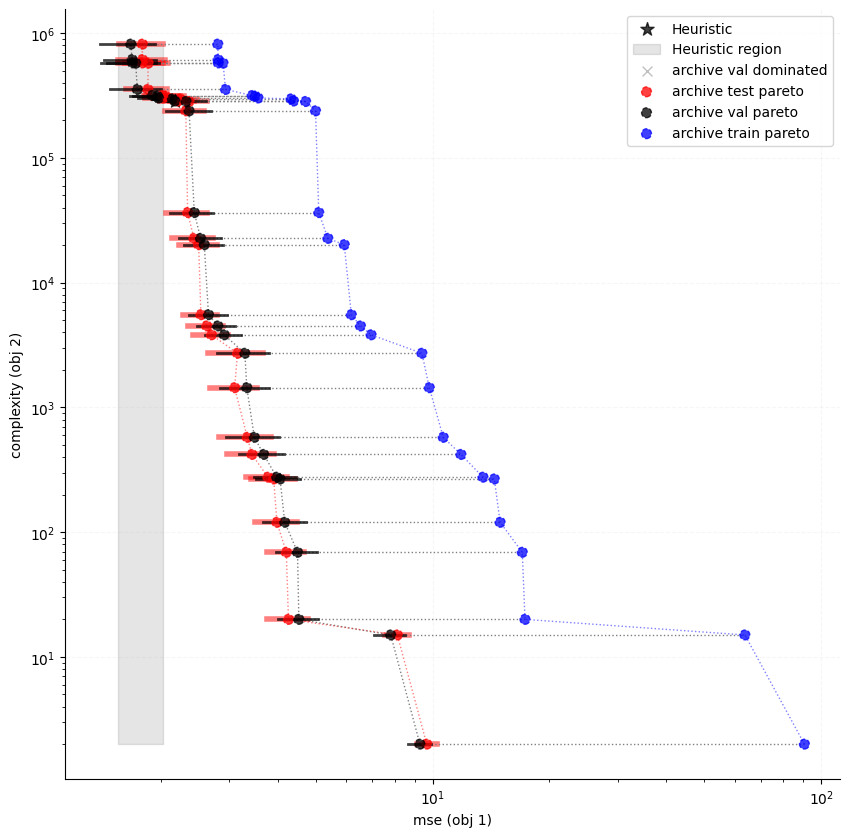

In [8]:
plt.figure(figsize=(10, 10))

display(final_model.drop(columns=['repr', 'pred_proba']))
print(final_model['repr'])

# Highlighting the heuristic
plt.scatter(final_model['Validation Loss'], final_model['Complexity'], alpha=0.75, c='k',
            marker='*', s=100,
            linewidth=1.0, label=f'Heuristic')

# Plot confidence interval used
print(final_model['Validation Loss'], cily, ciuy)
plt.fill_betweenx([np.min(df_results['Complexity']), np.max(df_results['Complexity'])],
                    cily, ciuy, alpha=0.1, color='black',
                    label='Heuristic region', zorder=-999999)

xset,yset = [], []
for point in PF:
    if (len(xset) > 0 ) and (train_loss[point] == xset[-1] and complexity[point] == yset[-1]):
        continue # avoid repeated individuals with different constants

    # Dashed line connecting train val test
    plt.hlines(y=complexity[point],
                xmin=np.min((train_loss[point], test_loss[point], val_loss[point])),
                xmax=np.max((train_loss[point], test_loss[point], val_loss[point])),
                color='gray', linestyle=':', linewidth=1, zorder=-999)
    
# group lines
# plt.plot(xset,yset, '--b', alpha=0.5, zorder=1)
plt.plot(val_loss[PF],   complexity[PF], ':k', alpha=0.5, linewidth=1.0, zorder=-999)
plt.plot(train_loss[PF], complexity[PF], ':b', alpha=0.5, linewidth=1.0, zorder=-999)
plt.plot(test_loss[PF],  complexity[PF], ':r', alpha=0.5, linewidth=1.0, zorder=-999)

# not in pareto front
plt.scatter(val_loss[not_PF], complexity[not_PF], alpha=0.25, c='k', zorder=-999,
            marker='x', s=50, linewidth=1.0, label=f'archive val dominated')    

# pareto front
plt.scatter(test_loss[PF], complexity[PF], alpha=0.75, c='r', ls='--', s=50,
            marker='o', linewidth=1.0, label=f'archive test pareto', zorder=999)
plt.scatter(val_loss[PF], complexity[PF], alpha=0.75, c='k', ls='--', s=50,
            marker='o', linewidth=1.0, label=f'archive val pareto', zorder=999)
plt.scatter(train_loss[PF], complexity[PF], alpha=0.75, c='b', ls='--', s=50,
            marker='o', linewidth=1.0, label=f'archive train pareto', zorder=999)

# test confidence intervals
for y, cilx, ciux in zip(complexity[PF], val_loss_lower[PF], val_loss_upper[PF]):
    plt.plot( [cilx,ciux], [y, y],
                alpha=0.75, lw=2, color='k', zorder=-999 )

for y, cilx, ciux in zip(complexity[PF], test_loss_lower[PF], test_loss_upper[PF]):
    plt.plot( [cilx,ciux], [y, y],
                alpha=0.5, lw=4, color='r', zorder=-9999 )

# adding final touches to the plot ---------------------------------------------
sns.despine()
plt.xscale("log")
plt.yscale("log")

plt.xlabel(f"{est.parameters_.objectives[0]} (obj 1)")
plt.ylabel(f"{est.parameters_.objectives[1]} (obj 2)")
plt.legend(loc='upper right')

plt.grid(ls='--', zorder=-999, alpha=0.1)
plt.show()

In [9]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

# Assuming df_results, PF, train_loss, val_loss, test_loss, complexity, etc., are defined

# Create a figure with subplots
fig = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])
fig.update_layout(height=800, width=1200)

# Heuristic region
heuristic_region = go.Scatter(
    x=[cily, ciuy, ciuy, cily],
    y=[np.min(df_results['Complexity']), np.min(df_results['Complexity']),
       np.max(df_results['Complexity']), np.max(df_results['Complexity'])],
    fill='toself',
    fillcolor='rgba(0,0,0,0.1)',
    line_color='rgba(255,255,255,0)',
    showlegend=False,
    hoverinfo='skip'  # Skip showing info for heuristic region
)

# Archive dominated
archive_dominated_trace = go.Scatter(
    x=val_loss[not_PF],
    y=complexity[not_PF],
    mode='markers',
    marker=dict(symbol='x', color='black'),
    opacity=0.25,
    name='Archive Val Dominated'
)

val_pareto_trace = go.Scatter(
    x=val_loss[PF],
    y=complexity[PF],
    mode='markers',
    marker=dict(color='red', symbol='circle'),
    opacity=1.0,
    name='Archive Val Pareto',
)

train_pareto_trace = go.Scatter(
    x=train_loss[PF],
    y=complexity[PF],
    mode='markers',
    marker=dict(color='blue', symbol='circle'),
    opacity=1.0,
    name='Archive Train Pareto'
)

# Pareto front
pareto_front_trace = go.Scatter(
    x=test_loss[PF],
    y=complexity[PF],
    mode='lines+markers',
    marker=dict(color='black', symbol='circle'),
    opacity=1.0,
    name='Archive Test Pareto',
    hovertemplate=("<b>PF Index</b>: %{customdata}<br>"
                   "<b>Test Loss</b>: %{x}<br>"
                   "<b>Complexity</b>: %{y}<br>"
                   "<b>Representation</b>:<br>%{text}"
                   ),
    text=['<br>'.join(t.split('\n')) for t in repr[PF]],
    customdata=np.expand_dims(PF, axis=1)
)

# Heuristic selection
heuristic_trace = go.Scatter(
    x=[final_model['Test Loss']],
    y=[final_model['Complexity']],
    mode='markers',
    marker=dict(symbol='star', size=15, color='blue'),
    opacity=0.75,
    name='Heuristic',
    hovertemplate="<b>Test Loss</b>: %{x}<br><b>Complexity</b>: %{y}<br><b>Representation</b>:<br>%{text}",
    text=['<br>'.join(final_model['repr'].split('\n'))]
)

# Add traces to the figure
fig.add_trace(heuristic_trace, secondary_y=False)
fig.add_trace(heuristic_region, secondary_y=False)
fig.add_trace(pareto_front_trace, secondary_y=False)
fig.add_trace(val_pareto_trace, secondary_y=False)
fig.add_trace(train_pareto_trace, secondary_y=False)
fig.add_trace(archive_dominated_trace, secondary_y=False)

# Add dashed lines for Pareto front
for i in range(len(PF)):
    fig.add_shape(type="line",
                  xref="x", yref="y",
                  x0=train_loss[PF[i]], y0=complexity[PF[i]],
                  x1=test_loss[PF[i]], y1=complexity[PF[i]],
                  line=dict(dash="dot", width=1, color="gray"))

# Add confidence intervals
for i in range(len(PF)):
    fig.add_shape(type="rect",
                  xref="x", yref="y",
                  x0=test_loss_lower[PF[i]], y0=complexity[PF[i]] - 0.001 * complexity[PF[i]],
                  x1=test_loss_upper[PF[i]], y1=complexity[PF[i]] + 0.001 * complexity[PF[i]],
                  line=dict(color="black", width=2), fillcolor="black", opacity=0.75)

# Update layout
fig.update_layout(
    xaxis_title=f"{est.parameters_.objectives[0]} (obj 1)",
    yaxis_title=f"{est.parameters_.objectives[1]} (obj 2)",
    xaxis=dict(type="log"),
    yaxis=dict(type="log"),
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=-0.3),
    margin=dict(l=50, r=50, t=50, b=50)
)

fig.show()

We can even create an interactive selector to visualize each program as a dot model!

In [10]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Create the dropdown using indices of Pareto front
index_dropdown = widgets.Dropdown(
    options=[(f"Program {i}", i) for i in PF],
    description='Pareto Front:',
    layout=widgets.Layout(width='400px')
)

# Setting an initial value
index_dropdown.value = PF[0] # The simplest model

# Output widget to display model info
output = widgets.Output()

def display_model_info(change):
    output.clear_output()
    i = change['new']
    with output:
        display(Markdown(
            f"### Program {i}/{len(PF)}\n"
            f"**Complexity**: {complexity[i]}\n\n"
            f"**Train Loss**: {train_loss[i]:.4f}\n\n"
            f"**Val Loss**: {val_loss[i]:.4f}\n\n"
            f"**Test Loss**: {test_loss[i]:.4f}\n\n"
        ))
        s = graphviz.Source(archive_estimators_[i].get_model("dot"))
        display(s)

index_dropdown.observe(display_model_info, names='value')

display(index_dropdown, output)

Dropdown(description='Pareto Front:', layout=Layout(width='400px'), options=(('Program 0', np.int64(0)), ('Pro…

Output()

In [11]:
est.partial_fit(X_train, y_train, lock_nodes_depth=99, keep_leaves_unlocked=False)


Completed 100% [====================]


,pop_size,100
,max_gens,100
,max_stall,0
,max_time,-1
,verbosity,1
,algorithm,'nsga2'
,mode,'regression'
,max_depth,5
,max_size,100
,num_islands,5
,mig_prob,0.05


In [12]:
import pandas as pd
from pybrush import BrushClassifier

# load data
df = pd.read_csv('../examples/datasets/d_analcatdata_aids.csv')
X = df.drop(columns='target')
y = df['target']

In [13]:
est = BrushClassifier(
    # functions=['Logistic', 'OffsetSum', 'SplitBest','Add','Mul','Sin','Cos','Exp','Logabs'],
    functions=['SplitBest','Add','Mul','Sin','Cos','Exp','Logabs'],
    objectives=["scorer", "linear_complexity"],
    scorer='balanced_accuracy', # brush implements several metrics for clf and reg!
    max_gens=50,
    pop_size=50,
    max_depth=10,
    max_size=30,
    verbosity=1,
)

est.fit(X, y)

print("Best model:", est.best_estimator_.get_model())
print('score:', est.score(X,y))

Completed 100% [====================]
Best model: Logistic(Sum(-0.04,0.05*Logabs(0.42*Add(12.22*Cos(51.97*Cos(1.00*Total)),-9.54*Sin(1.00*Add(1.00*AIDS,1.00*AIDS))))))
score: 0.66


In [14]:
est.partial_fit(X, y, lock_nodes_depth=999, keep_leaves_unlocked=False)
print("Best model:", est.best_estimator_.get_model())

Completed 100% [====================]
Best model: Logistic(Sum(-11.57,AIDS))
